## Investigating the Impact of Residual Connection to Convolutional Layer on EEG Classification Performance

### Experiment Summary:

**This experiment aims to explore the influence of residual connection with convolutional layers on the performance of EEG classification models. We investigate the relationship between the number of convolutional layers and the resulting accuracy.**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %mkdir /content/drive/MyDrive/ED_Experiments
# %mkdir /content/drive/MyDrive/ED_Experiments/ED_CNN_E13

In [ ]:
%cd /content/drive/MyDrive/ED_Experiments/ED_CNN_E13
%ls

/content/drive/MyDrive/ED_Experiments/ED_CNN_E13
'model_fold_1 (1).log'   model_fold_2.log   model_fold_3.png
 model_fold_1.log        model_fold_2.png   model_fold_4.log
 model_fold_1.png        model_fold_3.log   model_fold_4.png


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

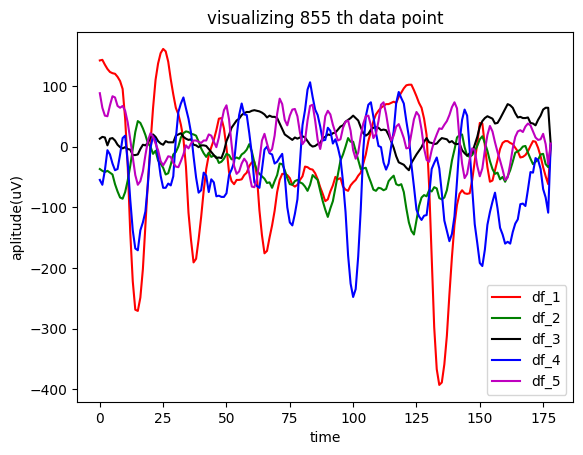

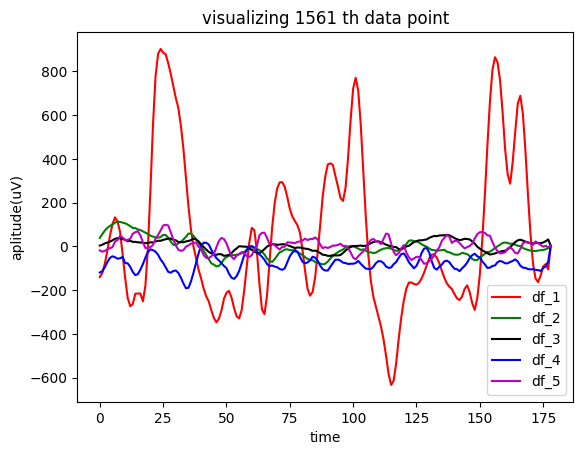

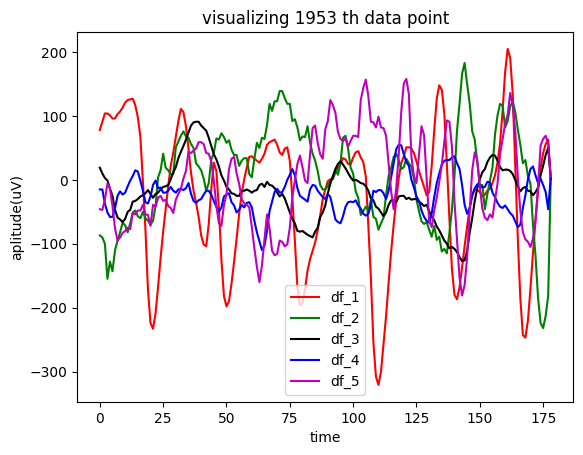

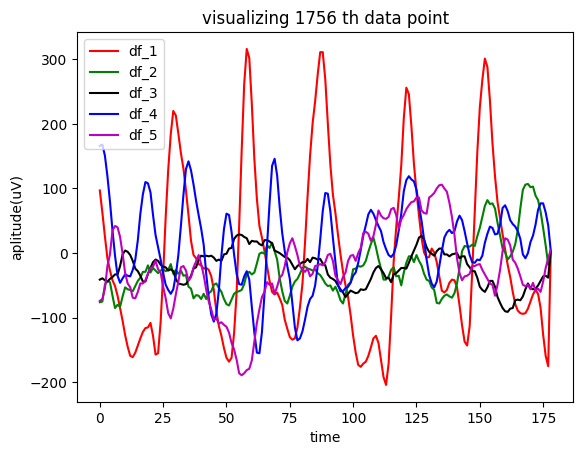

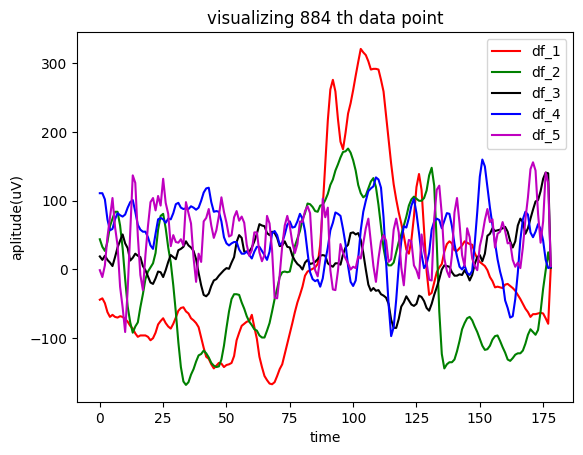

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the Residual Connection



In [ ]:
# class eegClassifier(keras.Model):
#     def __init__(self, input_shape):
#         super(eegClassifier, self).__init__()

#         self.conv_layers = 5

#         self.conv1 = layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')
#         self.bn1 = layers.BatchNormalization()
#         self.max_pool1 = layers.MaxPooling1D(2, padding='same')

#         self.conv2 = layers.Conv1D(filters=256, kernel_size=3, padding='valid', activation='relu')
#         self.bn2 = layers.BatchNormalization()
#         self.max_pool2 = layers.MaxPooling1D(2, padding='same')

#         self.conv3 = layers.Conv1D(filters=512, kernel_size=3, padding='valid', activation='relu')
#         self.bn3 = layers.BatchNormalization()
#         self.max_pool3 = layers.MaxPooling1D(2, padding='same')

#         self.conv4 = layers.Conv1D(filters=1024, kernel_size=3, padding='valid', activation='relu')
#         self.bn4 = layers.BatchNormalization()
#         self.max_pool4 = layers.MaxPooling1D(2, padding='same')

#         self.conv5 = layers.Conv1D(filters=2048, kernel_size=3, padding='valid', activation='relu')
#         self.bn5 = layers.BatchNormalization()
#         self.max_pool5 = layers.MaxPooling1D(2, padding='same')

#         self.flatten = layers.Flatten()

#         self.dense_1 = layers.Dense(128, activation='relu')
#         self.dense_2 = layers.Dense(32, activation='relu')

#         self.output_dense = layers.Dense(1, activation='sigmoid')

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.max_pool1(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.max_pool2(x)

#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.max_pool3(x)

#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = self.max_pool4(x)

#         x = self.conv5(x)
#         x = self.bn5(x)
#         x = self.max_pool5(x)

#         x = self.flatten(x)
#         x = self.dense_1(x)
#         x = self.dense_2(x)

#         return self.output_dense(x)


In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# def residual_block(x, filters, kernel_size, padding='same', activation='relu'):
#     shortcut = x
#     x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation(activation)(x)
#     x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Add()([shortcut, x])
#     x = layers.Activation(activation)(x)
#     return x

# def create_residual_eeg_model(input_shape):
#     inputs = keras.Input(shape=input_shape)
#     x = layers.Conv1D(filters=128, kernel_size=5, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=128, kernel_size=5)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=256, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=256, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=512, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=512, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=1024, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=1024, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Conv1D(filters=2048, kernel_size=3, padding='valid')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = residual_block(x, filters=2048, kernel_size=3)
#     x = layers.MaxPooling1D(2, padding='same')(x)

#     x = layers.Flatten()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dense(32, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     model = keras.Model(inputs=inputs, outputs=outputs)
#     return model


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def residual_block(x, filters, kernel_size, padding='same', activation='relu'):
    shortcut = x
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation(activation)(x)
    return x

def create_residual_eeg_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=128, kernel_size=5, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=128, kernel_size=5)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=1024, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=1024, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=2048, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=2048, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.GlobalAveragePooling1D()(x)  # Replace Flatten layer with GlobalAveragePooling1D
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model





---- fold = 1 ------

Epoch 1/100
288/288 [==============================] - 54s 101ms/step - loss: 0.1269 - accuracy: 0.9601 - val_loss: 0.0600 - val_accuracy: 0.9809
Epoch 2/100
288/288 [==============================] - 23s 80ms/step - loss: 0.1062 - accuracy: 0.9649 - val_loss: 0.0609 - val_accuracy: 0.9783
Epoch 3/100
288/288 [==============================] - 23s 80ms/step - loss: 0.0766 - accuracy: 0.9716 - val_loss: 0.0764 - val_accuracy: 0.9709
Epoch 4/100
288/288 [==============================] - 35s 123ms/step - loss: 0.0782 - accuracy: 0.9748 - val_loss: 0.0451 - val_accuracy: 0.9843
Epoch 5/100
288/288 [==============================] - 24s 84ms/step - loss: 0.0708 - accuracy: 0.9747 - val_loss: 0.0471 - val_accuracy: 0.9835
Epoch 6/100
288/288 [==============================] - 32s 111ms/step - loss: 0.0548 - accuracy: 0.9828 - val_loss: 0.0512 - val_accuracy: 0.9861
Epoch 7/100
288/288 [==============================] - 23s 80ms/step - loss: 0.0550 - accuracy: 0.9811 

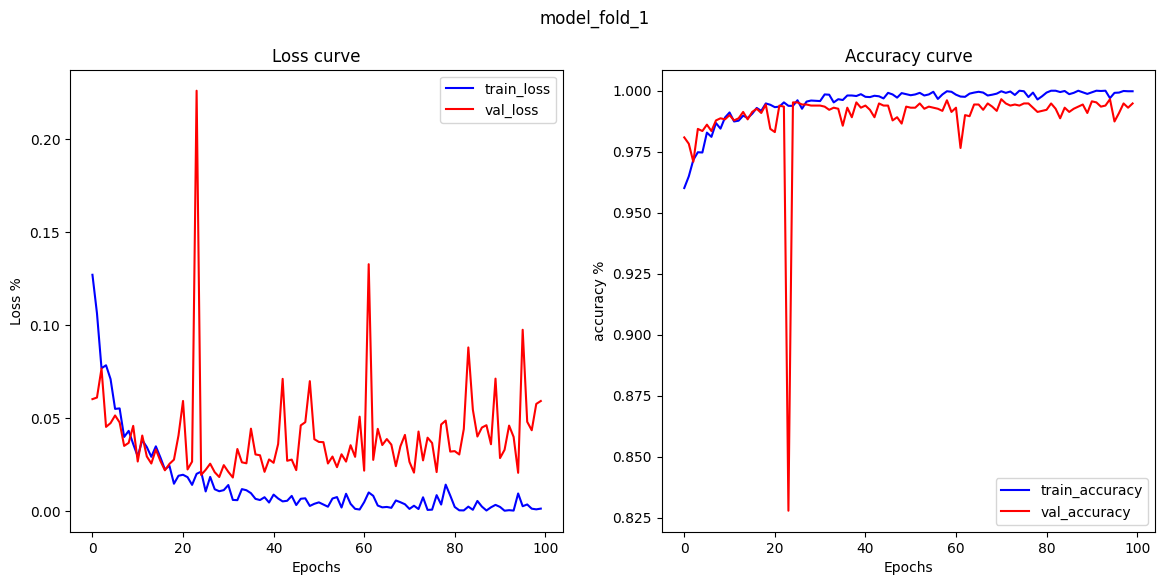



---- fold = 2 ------

Epoch 1/100
288/288 [==============================] - 44s 101ms/step - loss: 0.1536 - accuracy: 0.9486 - val_loss: 0.2061 - val_accuracy: 0.8800
Epoch 2/100
288/288 [==============================] - 30s 103ms/step - loss: 0.1111 - accuracy: 0.9612 - val_loss: 0.0928 - val_accuracy: 0.9713
Epoch 3/100
288/288 [==============================] - 26s 89ms/step - loss: 0.0768 - accuracy: 0.9733 - val_loss: 0.0491 - val_accuracy: 0.9809
Epoch 4/100
288/288 [==============================] - 25s 86ms/step - loss: 0.0792 - accuracy: 0.9709 - val_loss: 0.0993 - val_accuracy: 0.9596
Epoch 5/100
288/288 [==============================] - 24s 84ms/step - loss: 0.0652 - accuracy: 0.9777 - val_loss: 0.1388 - val_accuracy: 0.9417
Epoch 6/100
288/288 [==============================] - 36s 125ms/step - loss: 0.0522 - accuracy: 0.9826 - val_loss: 0.0374 - val_accuracy: 0.9843
Epoch 7/100
288/288 [==============================] - 33s 114ms/step - loss: 0.0737 - accuracy: 0.9763

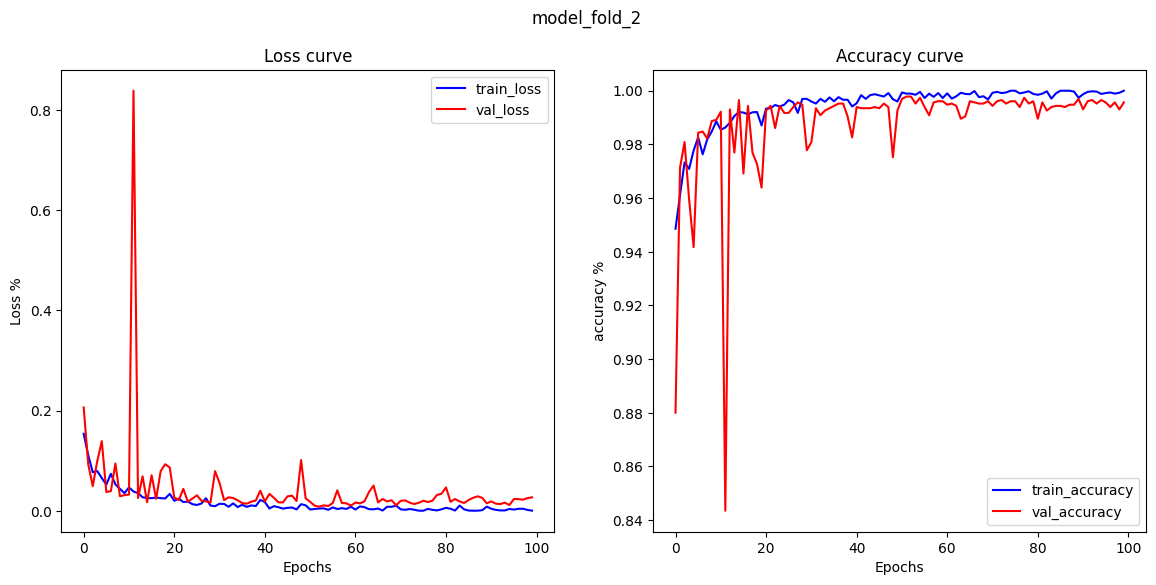



---- fold = 3 ------

Epoch 1/100
288/288 [==============================] - 45s 105ms/step - loss: 0.1328 - accuracy: 0.9545 - val_loss: 0.0623 - val_accuracy: 0.9813
Epoch 2/100
288/288 [==============================] - 25s 87ms/step - loss: 0.1079 - accuracy: 0.9625 - val_loss: 0.0618 - val_accuracy: 0.9778
Epoch 3/100
288/288 [==============================] - 33s 114ms/step - loss: 0.0805 - accuracy: 0.9720 - val_loss: 0.0441 - val_accuracy: 0.9848
Epoch 4/100
288/288 [==============================] - 32s 111ms/step - loss: 0.0742 - accuracy: 0.9736 - val_loss: 0.0452 - val_accuracy: 0.9852
Epoch 5/100
288/288 [==============================] - 25s 87ms/step - loss: 0.0638 - accuracy: 0.9802 - val_loss: 0.0607 - val_accuracy: 0.9778
Epoch 6/100
288/288 [==============================] - 34s 119ms/step - loss: 0.0738 - accuracy: 0.9767 - val_loss: 0.0502 - val_accuracy: 0.9857
Epoch 7/100
288/288 [==============================] - 30s 104ms/step - loss: 0.0626 - accuracy: 0.978

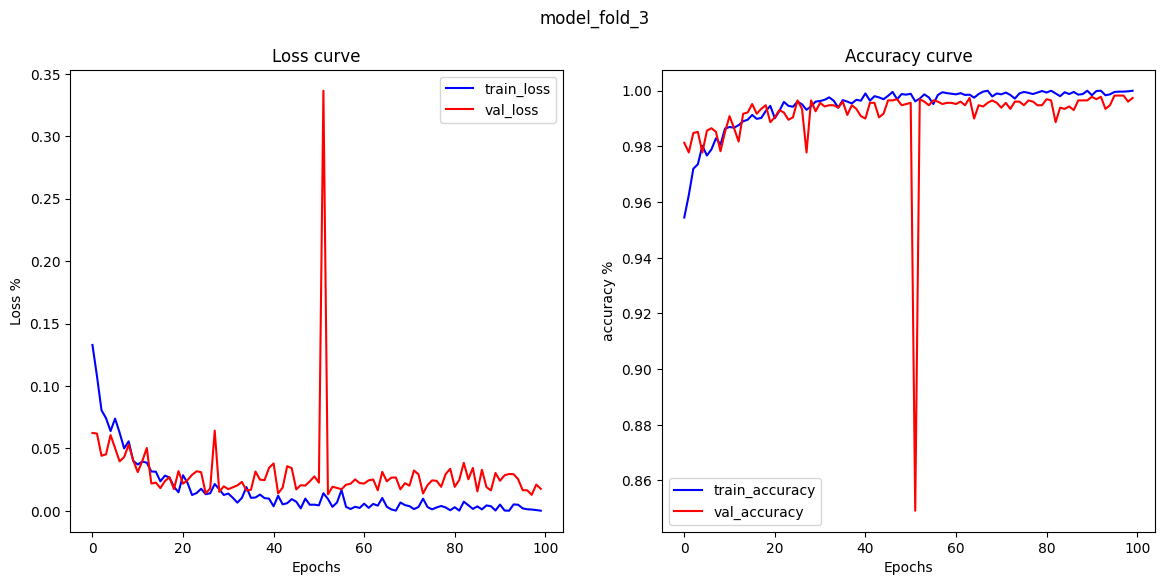



---- fold = 4 ------

Epoch 1/100
288/288 [==============================] - 43s 102ms/step - loss: 0.1294 - accuracy: 0.9570 - val_loss: 0.2734 - val_accuracy: 0.8935
Epoch 2/100
288/288 [==============================] - 33s 116ms/step - loss: 0.0814 - accuracy: 0.9701 - val_loss: 0.0541 - val_accuracy: 0.9839
Epoch 3/100
288/288 [==============================] - 25s 86ms/step - loss: 0.0720 - accuracy: 0.9743 - val_loss: 0.0972 - val_accuracy: 0.9757
Epoch 4/100
288/288 [==============================] - 25s 85ms/step - loss: 0.0721 - accuracy: 0.9761 - val_loss: 0.0672 - val_accuracy: 0.9752
Epoch 5/100
288/288 [==============================] - 34s 120ms/step - loss: 0.0474 - accuracy: 0.9833 - val_loss: 0.0325 - val_accuracy: 0.9861
Epoch 6/100
288/288 [==============================] - 25s 87ms/step - loss: 0.0590 - accuracy: 0.9790 - val_loss: 0.0456 - val_accuracy: 0.9848
Epoch 7/100
288/288 [==============================] - 36s 125ms/step - loss: 0.0441 - accuracy: 0.9854

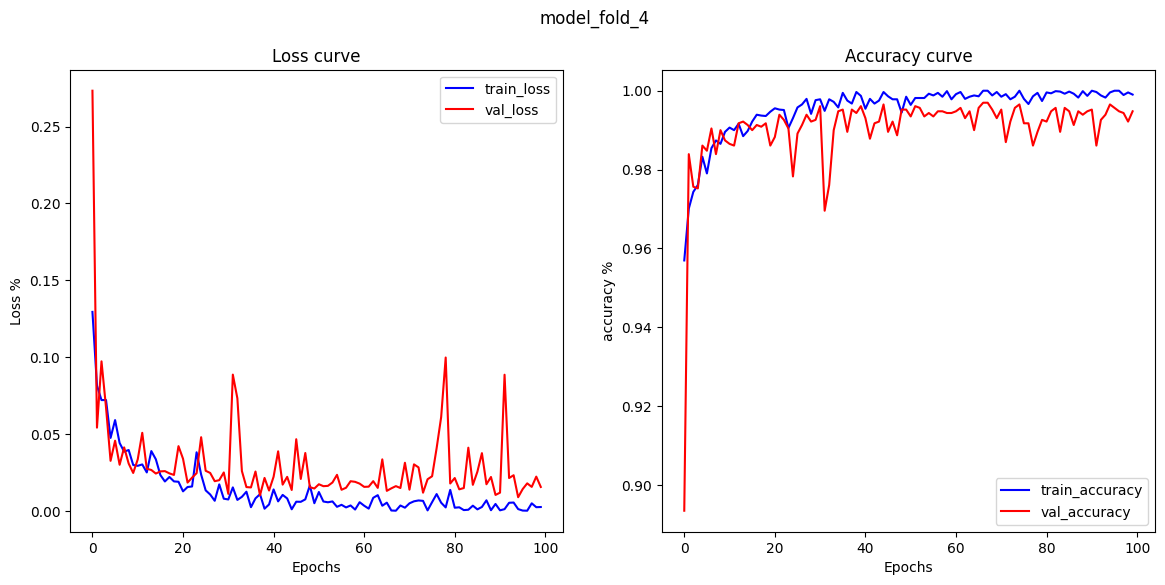



---- fold = 5 ------

Epoch 1/100
288/288 [==============================] - 43s 100ms/step - loss: 0.1563 - accuracy: 0.9486 - val_loss: 0.3525 - val_accuracy: 0.8217
Epoch 2/100
288/288 [==============================] - 34s 119ms/step - loss: 0.0897 - accuracy: 0.9707 - val_loss: 0.0627 - val_accuracy: 0.9765
Epoch 3/100
288/288 [==============================] - 36s 126ms/step - loss: 0.0779 - accuracy: 0.9750 - val_loss: 0.0568 - val_accuracy: 0.9852
Epoch 4/100
288/288 [==============================] - 25s 88ms/step - loss: 0.0703 - accuracy: 0.9760 - val_loss: 0.0595 - val_accuracy: 0.9796
Epoch 5/100
288/288 [==============================] - 25s 86ms/step - loss: 0.0658 - accuracy: 0.9772 - val_loss: 0.0726 - val_accuracy: 0.9752
Epoch 6/100
288/288 [==============================] - 35s 123ms/step - loss: 0.0528 - accuracy: 0.9822 - val_loss: 0.0428 - val_accuracy: 0.9857
Epoch 7/100
288/288 [==============================] - 37s 128ms/step - loss: 0.0496 - accuracy: 0.983

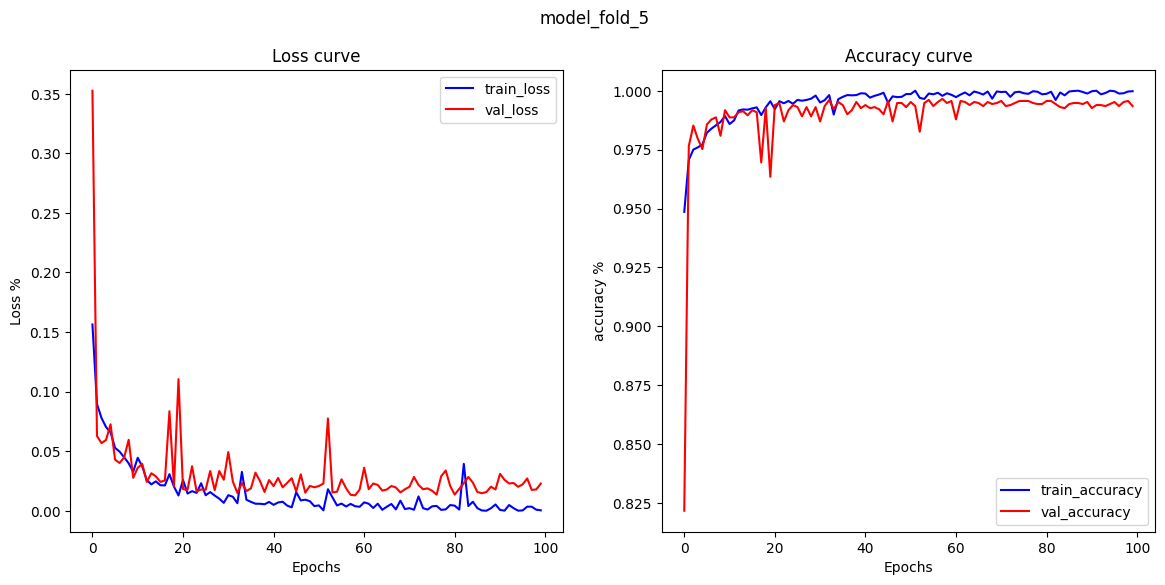

Mean Accuracy: 0.9952173948287963


In [ ]:

# Perform cross-validation
fold_accuracy = []
fold = 1

for train_index, val_index in skf.split(X, y):
    X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)


    # model = eegClassifier(input_shape)
    model = create_residual_eeg_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    log_file = f"model_fold_{fold}.log"
    model_name = f"model_fold_{fold}.h5"

    # Clear existing log handlers and close log files
    root_logger = logging.getLogger()
    for handler in root_logger.handlers:
        handler.close()
    root_logger.handlers.clear()

    # Create a separate log file for each model
    logger = init_logger(log_file, stdout=False)


    logger.info(f"\n\n---- fold = {fold} -------\n")
    print(f"\n\n---- fold = {fold} ------\n")

    # Define the checkpoint callback to save the best model
    checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

    # Train the model and capture the history
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                        callbacks=[checkpoint])

    # Log loss and accuracy
    for i, (loss, accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
        logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy}")
    for i, (val_loss, val_accuracy) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy'])):
        logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


    # Evaluate the model on the test set
    loss_scale_optimizer, accuracy = model.evaluate(X_val, y_val)
    fold_accuracy.append(accuracy)

    # Log fold accuracy
    logger.info(f"model_Fold = {fold} accuracy: {accuracy}")

    print(f"model_Fold = {fold} accuracy: {accuracy}")
    plot_loss_accuracy(history, f"model_fold_{fold}")
    # plot_accuracy(history)

    fold += 1

# Calculate the average accuracy across all folds
mean_accuracy = np.mean(fold_accuracy)
print("Mean Accuracy:", mean_accuracy)